In [1]:
%run setup.py

In [2]:
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from sklearn import datasets
from sklearn.preprocessing import scale
import numpy as np
import matplotlib.pyplot as plt

In [15]:
from relevance_preserving_map.circular_som import CircularSOM, get_grid_position_som

## load sample dataset

In [4]:
digits = datasets.load_digits(n_class=10)
data = digits.data  # matrix where each row is a vector that represent a digit.
data = scale(data)
num = digits.target

# generate a pseudo relevance score with smaller number take up higher relevance
relevance = 1/(num+1)
_relevance = np.exp(relevance)
relevance = (_relevance - np.min(_relevance))/(np.max(_relevance) - np.min(_relevance))

## Sample usage of CircularSOM

In [12]:
# Define input data
# data: numpy array of shape (n_samples, n_features)
# relevance: numpy array of shape (n_samples,)
# The 'data' array represents the high-dimensional data points to be projected,
# and 'relevance' is a score representing the importance of each data point.
digits = datasets.load_digits(n_class=10)
data = digits.data  # matrix where each row is a vector that represent a digit.
data = scale(data)
num = digits.target

# generate a pseudo relevance score with smaller number take up higher relevance
relevance = 1/(num+1)
_relevance = np.exp(relevance)
relevance = (_relevance - np.min(_relevance))/(np.max(_relevance) - np.min(_relevance))

# Parameters for SOM training
num_neurons_step = 8  # Number of neurons in the first layer of the SOM grid
num_layers = 21  # Number of layers in the circular SOM grid
input_dimension = data.shape[1]  # Dimensionality of the input data (number of features)

# Define similarity weight (w_s) and relevance weight (w_r)
# These weights balance the importance of similarity and relevance during training.
# w_s: Weight for similarity between data points (default: 0.2)
# w_r: Weight for relevance of each data point (default: 0.8)
similarity_weight = 0.2
relevance_weight = 0.8

# Training parameters
num_iterations = data.shape[0] * 10  # Number of iterations, typically 10x the number of samples
learning_rate = 0.7  # Initial learning rate
sigma = 1.5  # Initial value for neighborhood size
activation_distance = 'euclidean'  # Distance metric used in the SOM (options: 'euclidean', etc.)
topology = 'circular'  # Topology of the SOM grid (circular in this case)
neighborhood_function = 'gaussian'  # Type of neighborhood function ('gaussian' in this case)
random_seed = 10  # Random seed for reproducibility
verbose = True  # Whether to print progress during training
report_error = True  # Whether to report quantization error during training
use_sorted = True  # Whether to sort data based on relevance during training

# Initialize CircularSOM
som = CircularSOM(
    step=num_neurons_step,
    layer=num_layers,
    input_len=input_dimension,
    sigma=sigma,
    learning_rate=learning_rate,
    activation_distance=activation_distance,
    topology=topology,
    neighborhood_function=neighborhood_function,
    random_seed=random_seed
)

# Train the SOM
# The relevance and similarity weights balance the training process, where:
# - Similarity weight controls how similar points should be grouped together.
# - Relevance weight ensures important data points are placed near the center.
som.train(
    data=data,
    relevance_score=relevance,
    num_iteration=num_iterations,
    w_s=similarity_weight,
    w_r=relevance_weight,
    verbose=verbose,
    report_error=report_error,
    use_sorted=use_sorted
)


 [     0 / 17970 ]   0% - ? it/s
Dual quantization error at epoch 1: 0.03468212281989521
Starting epoch 2
 [  1797 / 17970 ]  10% - 0:00:24 left 
Dual quantization error at epoch 2: 0.018986348131336626
Starting epoch 3
 [  3594 / 17970 ]  20% - 0:00:21 left 
Dual quantization error at epoch 3: 0.012646012951871476
Starting epoch 4
 [  5391 / 17970 ]  30% - 0:00:19 left 
Dual quantization error at epoch 4: 0.008106491761173139
Starting epoch 5
 [  7188 / 17970 ]  40% - 0:00:16 left 
Dual quantization error at epoch 5: 0.006291594013243226
Starting epoch 6
 [  8985 / 17970 ]  50% - 0:00:13 left 
Dual quantization error at epoch 6: 0.0049387782975089094
Starting epoch 7
 [ 10782 / 17970 ]  60% - 0:00:11 left 
Dual quantization error at epoch 7: 0.003953368233931769
Starting epoch 8
 [ 12579 / 17970 ]  70% - 0:00:08 left 
Dual quantization error at epoch 8: 0.0032989120354115792
Starting epoch 9
 [ 14376 / 17970 ]  80% - 0:00:05 left 
Dual quantization error at epoch 9: 0.0029906974439698

## Extract results using the get_grid_position_som function

In [16]:
# ids_same_order is just the index of data in the same order as it was passed
ids_same_order = np.arange(data.shape[0])

# Get grid positions for each data point after training
data_grid_positions = get_grid_position_som(som, data, relevance, ids_same_order)

# Draw projection

In [20]:
import matplotlib.pyplot as plt
import numpy as np

def plot_som_results(som, data, labels, relevance, sort=False):
    """
    Visualizes the SOM results by plotting each data point on the SOM grid.
    
    Parameters:
    - som: The trained CircularSOM object.
    - data: The input data (e.g., images or feature vectors) to be plotted.
    - labels: The labels or identifiers of the data points (e.g., numbers 0 to 9 for the MNIST dataset).
    - relevance: The relevance scores for each data point, which can influence the visualization.
    - sort: Whether to sort the data points by their relevance scores (default: False).
    
    Returns:
    - data_relevance: List of relevance scores corresponding to the plotted data points.
    - data_occupied: List of SOM grid positions occupied by the data points based on relevance.
    """
    # Initialize the resource map (if using relevance in your SOM)
    som.initialize_resource_map()

    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111)

    data_relevance = []
    data_occupied = []
    
    wmap = {}
    total_loss = 0

    # Prepare data for plotting
    # Zip together data, labels (num), and relevance for easy access
    # Optionally sort the data by relevance scores in descending order
    modified_data = zip(data, labels, relevance)
    if sort:
        modified_data = sorted(zip(data, labels, relevance), key=lambda t: t[2], reverse=True)

    for idx, (x, label, rel_score) in enumerate(modified_data):
        # Find the best matching unit (BMU) on the SOM for the data point
        bmu_index, loss = som.winner(x, rel_score, return_distance=True)
        
        # Store relevance score and occupied grid position
        data_relevance.append(rel_score)
        data_occupied.append(som._weights_radius[bmu_index])

        # Accumulate the quantization loss (if tracking performance)
        total_loss += loss

        # Get the grid location of the BMU (coordinates on the SOM grid)
        bmu_location = som._grid[bmu_index]
        
        # Add the data point's label as text at its grid location
        plt.text(bmu_location[0] + 0.5, bmu_location[1] + 0.5, str(label),
                 color=plt.cm.rainbow(label / 10.0),  # Color based on label value
                 fontdict={'weight': 'bold', 'size': 11})

        # Map the BMU index to the current data point's index
        wmap[bmu_index] = idx


    grid_x_min, grid_x_max = np.min(som._grid[:, 0]), np.max(som._grid[:, 0])
    grid_y_min, grid_y_max = np.min(som._grid[:, 1]), np.max(som._grid[:, 1])
    ax.set_xlim(grid_x_min - 2, grid_x_max + 2)
    ax.set_ylim(grid_y_min - 2, grid_y_max + 2)

    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xticklabels([])
    ax.set_yticklabels([])

    for spine in ax.spines.values():
        spine.set_visible(False)

    plt.show()
    
    return data_relevance, data_occupied


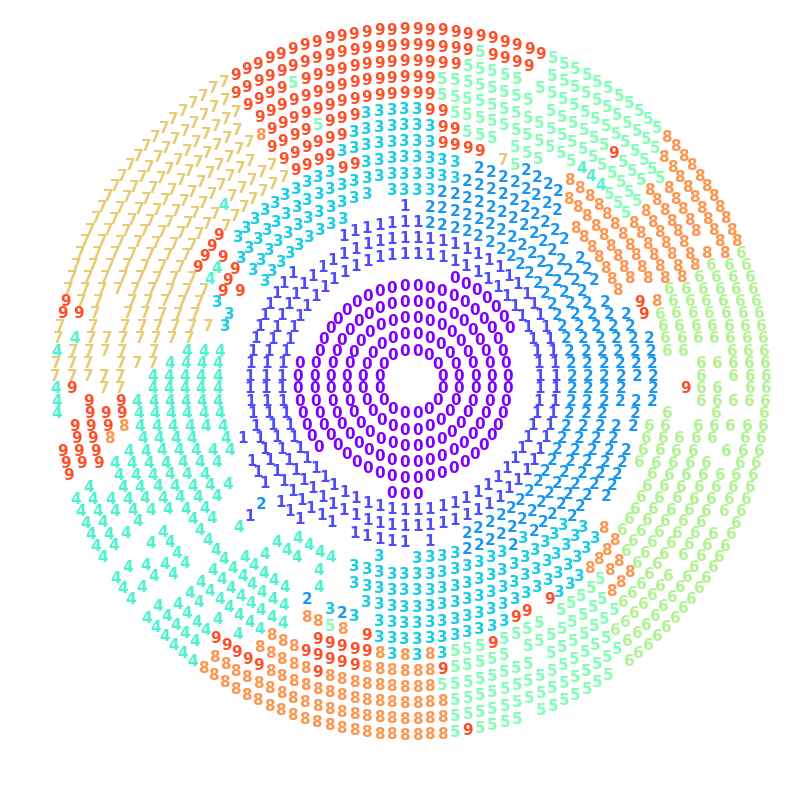

In [21]:
data_relevance, data_occupied = plot_res(som, data, num, relevance)